# Group Velocity

This notebook reads in grouped eigenvalues for a single central k-point as output by the `Export` code. It is meant to speed up the process of aligning crossed bands, determining which bands should go together across the coordinates, and getting the slope of all of the bands.

For Si, Guanzhi did the $\Gamma$-point values, but I did the other ones. In our case, all k-points with the same number of non-zero coordinates were the same, so I only did this process explicitly for a subset of the k-points. That may be the case in general, but you should confirm it in your own system.

## Setup

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
HBAR = 6.582e-16 # Unit: eV s
HARTREE_TO_EV = 27.211
HARTREEAU_TO_ANG = 0.529177210903
ANG_TO_CM = 1e-8

PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/VASPAndExport/pristine/groupVelocity/4'

I defined my k-points in direct coordinates, so I needed to convert from direct to Cartesian coordinates. The way to do this is to do a matrix multiplication between the reciprocal lattice vectors and the direct coordinates. In the case of Si, there are not off-diagonal terms in the lattice vectors, I only displaced in one coordinate direction at a time for the displaced k-points, and all of the diagonal elements were the same, so I only needed that value that is along the diagonal. *If any of these are not true for your case, you will need to change this to use the full matrix.*

This number is expected to be in Hartree atomic units. I got it from the `input` file output by the `Export` code. 

In [ ]:
RECIP_LATT_VEC = 1.520070928286644E-001 # Hartree a.u.

### Set up helper functions

The `read_grouped_eigenvalues` function is set up to read the eigenvalues as output from the `Export` code in the `groupedEigenvalues.isp.ik` files. **Make sure to change the bands that are being read to match your system.** I would suggest starting at the band edge and working your way out from there. It is helpful to include bands past the ones you actually need velocities for because sometimes the last bands you need are crossed over with others. 

The `read_grouped_eigenvalues` function is called for each k-point and coordinate individually. `eigv` has shape `(nBandsRead,nDispK)`, where `nDispK` is the number of displaced k-points included in the grouped eigenvalues file.

In [3]:
def read_grouped_eigenvalues(file_path):
    eigenvalues = np.loadtxt(file_path, skiprows=4)
    # CHANGE THE BAND LIMITS HERE
    eigv = eigenvalues[1024:1095,:-1] # Skip the last column with the occupation
    return eigv

The `line_up_bands` function is meant to help with uncrossing bands. By default, the bands are just labeled at each k-point individually in order of increasing energy. However, if the bands cross, the labels will not match. We need to match the k-points up correctly in order to get an accurate slope for the group velocity. 

The `line_up_bands` function is called for one k-point and coordinate at a time. It expects an array (`arr`) of shape `(nBandsRead,nDispK)`. The value at a specific displaced k-point index `idk` is stored for two different band indices `ib1` and `ib2`. The values are then swapped and stored back in the original array, and the updated array is returned. 

In [4]:
def line_up_bands(arr,ib1,ib2,idk):
    save1 = arr[ib1,idk]
    save2 = arr[ib2,idk]
    arr[ib1,idk] = save2
    arr[ib2,idk] = save1
    return arr

The `swap_bands` function is meant to swap the band index of two bands across all displaced k-points. We need this in order to make sure that all bands within a degeneracy group have the same total group velocity once the coordinates are combined. In order to accomplish this, the combination of high/slow slope bands must be equal across the coordinates. 

The `swap_bands` function takes an array of shape `(nBandsRead,nDispK)`, copies the values across each displaced k-point for two different band indices, then swaps the values and stores them back in the original array, which is then returned. 

In [5]:
def swap_bands(arr,ib1,ib2):
    save1 = np.copy(arr[ib1])
    save2 = np.copy(arr[ib2])
    arr[ib1] = save2
    arr[ib2] = save1
    return arr

## Read in base eigenvalues

Define the number of central k-points in your calculation and the displacement pattern. I did a calculation for one central k-point at a time, so the k-point index was always 1, but you could do them all together and read them with this loop. **Make sure to set the spin index (the first number in the grouped eigenvalues file name) to the one that you need.** 

In [35]:
# Inputs
num_k_points = 1
dispPattern = [-0.01, 0.00, 0.01, 0.02]
eigs = []

# Read transition rates and energies for each k-point
for ik in range(num_k_points):
    eigs_k = []
    
    file_path = f'{PATH}/groupedEigenvaluesX.1.{ik+1}'
    eigv = read_grouped_eigenvalues(file_path)
    eigs_k.append(eigv)
    
    file_path = f'{PATH}/groupedEigenvaluesY.1.{ik+1}'
    eigv = read_grouped_eigenvalues(file_path)
    eigs_k.append(eigv)
    
    file_path = f'{PATH}/groupedEigenvaluesZ.1.{ik+1}'
    eigv = read_grouped_eigenvalues(file_path)
    eigs_k.append(eigv)
    
    eigs.append(eigs_k)

        
eigs = np.array(eigs)

You can also read in the lined-up eigenvalues stored from a previous usage of this notebook. I have this set up so that the cell above is run first and the bands that I considered (indexed to 64) were overwritten by the `linedUpEigs` files. 

In [36]:
for ik in range(num_k_points):
    eigs[ik,0,:64,:] = np.loadtxt(f'{PATH}/linedUpEigsX.{ik+1}')
    eigs[ik,1,:64,:] = np.loadtxt(f'{PATH}/linedUpEigsY.{ik+1}')
    eigs[ik,2,:64,:] = np.loadtxt(f'{PATH}/linedUpEigsZ.{ik+1}')

In [315]:
print(eigs.shape)

(1, 3, 71, 5)


## Plot and rearrange to line up bands correctly

Plot a range of bands. It is useful to plot several bands until you narrow down the degeneracy group, then narrow into one group at a time to line up and swap bands as needed. The three-row figure is helpful for looking at the bands in more detail and the three-column figure is helpful for getting an overview of all of the bands at once. The plots are in the order $x,y,z$. 

Start with `base=0`, then adjust the number of bands shown using `nBandsShown`. As you complete lining up bands, increase `base` until all the bands you need are lined up.

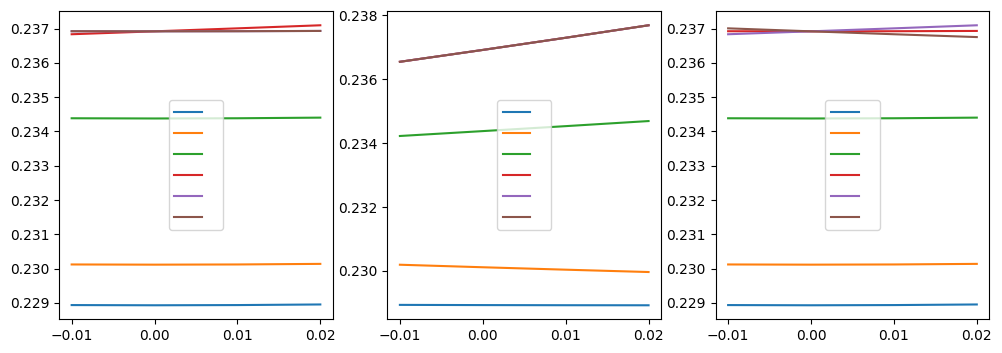

In [15]:
#fig, axes = plt.subplots(3, 1, figsize=(6,18))  # 3 rows, 1 column
fig, axes = plt.subplots(1, 3, figsize=(12,4))  # 1 row, 3 columns

ik=0

base = 0
nBandsShown = 6

for ix in range(3):
    for ib in range(base,base+nBandsShown):
        axes[ix].plot(dispPattern, eigs[ik,ix,ib],label=' ')        
        axes[ix].legend()

It can take quite a bit of time to line up the bands, so it is helpful to store the array as you go so that you have a point to "undo" to if you make a mistake. I would recommend storing this after each degeneracy group that you line up.

In [302]:
undo = np.copy(eigs)
#eigs = np.copy(undo)

### Line up crossed bands

The `line_up_bands` function swaps the band index for a single coordinate `ix` and displaced-k-point index `idk`. There are some configurations that are reoccurring and some that are unique. I kept two cells so that I wouldn't have to keep rewriting the standard setup each time I encountered a unique one. 

List the coordinate indices in the `ixs` array, the displaced-k-point indices in `idks`, and the indices of the bands to swap in the `pairs` array. The bands are indexed above the `base` defined in the plotting cell. Only one of the next two cells should be run to define these values, then run the cell with the call to `line_up_bands`. Check out the plot above to confirm that you did what you meant to.

In [268]:
# Standard
ixs = [0]
idks = [2]
pairs = [[0,3],[1,2]]
#pairs = [[0,1]]
#pairs = [[0,7],[1,6],[2,5],[3,4]]

In [295]:
# Unique
ixs = [0,1]
idks = [2]
pairs = [[0,13]]

In [296]:
for ix in ixs:
    for idk in idks:
        for pair in pairs:
            eigs[ik,ix,:] = line_up_bands(eigs[ik,ix,:],base+pair[0],base+pair[1],idk)

### Swap bands

*After the bands are lined up*, swap entire bands so that the group velocity is the same for all bands within a degeneracy group.

In [270]:
ix = 1
#pairs = [[0,1]]#,[2,3]]
pairs = [[0,2],[1,3]]

for pair in pairs:
    eigs[ik,ix,:] = swap_bands(eigs[ik,ix,:],base+pair[0],base+pair[1])

## Save array with lined up bands

Save the array with bands lined up so that we can have it for future reference if needed.

In [279]:
np.savetxt(f'{PATH}/linedUpEigsX.{ik+1}', eigs[ik,0,:64,:])
np.savetxt(f'{PATH}/linedUpEigsY.{ik+1}', eigs[ik,1,:64,:])
np.savetxt(f'{PATH}/linedUpEigsZ.{ik+1}', eigs[ik,2,:64,:])

## Get group velocities

Once all of the bands you need are lined up, the loop below calculates all of the slopes. I have encountered quadratic bands and linear bands, so I included fits to each of those. If the fit to a line is very good, the linear slope is used. Otherwise, the fit to a parabola is used. The equations below assume that the center k-point is treated as zero. The slope for each band and each direction is calculated independently, then the coordinates are combined to get a total group velocity for each band. The units are converted to cm/s based on the constants set at the beginning of this notebook.

In [37]:
vgs = []
order = np.zeros((3,64)) - 1

In [38]:
#fig, axes = plt.subplots(1, 3, figsize=(12,4))  # 1 row, 3 columns
ik = 0

dispFitPlot = np.linspace(dispPattern[0],dispPattern[-1],50)
vg = np.zeros((3))
R2 = np.zeros((2))
vg_fit = np.zeros((2))


for ib in range(0,64):
    for ix in range(3):
        for iorder in range(2):
            # Fit to polynomial
            p = np.polyfit(dispPattern, eigs[ik,ix,ib],iorder+1)
            
            # Get predicted values
            eigFit = np.polyval(p,dispPattern)
            eigFitPlot = np.polyval(p,dispFitPlot)
            
            # Get goodness of fit
            SSR = np.sum((eigFit-eigs[ik,ix,ib])**2)
            SST = np.sum((eigs[ik,ix,ib] - np.mean(eigs[ik,ix,ib]))**2)
            R2[iorder] = 1 - SSR/SST
            
            # vg = slope/hbar with unit conversion
            # Convert k length to Cartesian and cm
            vg_fit[iorder] = p[iorder]*(1/HBAR)*HARTREE_TO_EV*(1/(RECIP_LATT_VEC/(HARTREEAU_TO_ANG*ANG_TO_CM)))
            
            #print(f'{ib}, {ix}, {iorder+1}, {R2[iorder]:.5f}, {vg_fit[iorder]:.2e}')
            #axes[ix].plot(dispFitPlot, eigFitPlot)
            #axes[ix].plot(dispPattern, eigs[ik,ix,ib])
            
        if R2[0] > 0.99:
            vg[ix] = vg_fit[0]
            order[ix,ib] = 1
        else: 
            vg[ix] = vg_fit[1]
            order[ix,ib] = 2
            
    vgs.append(np.linalg.norm(vg))
    #print(f'{ib}, {order[:,ib]}')

I copied these values directly into a spreadsheet that I used for further analysis, but you can add saving them to a file.

In [39]:
for ib in range(0,64):
    print(f'{vgs[ib]:.2e}')

5.39e+07
5.39e+07
1.34e+07
5.33e+07
5.33e+07
4.70e+07
4.70e+07
5.99e+07
5.99e+07
2.31e+07
6.58e+07
6.58e+07
5.99e+07
5.99e+07
6.38e+07
6.38e+07
7.03e+07
7.03e+07
7.02e+07
7.02e+07
9.06e+07
9.06e+07
4.26e+07
4.24e+07
8.93e+07
8.93e+07
7.13e+07
7.13e+07
6.84e+07
6.84e+07
1.12e+08
6.66e+07
6.66e+07
7.30e+07
7.30e+07
7.10e+07
7.10e+07
9.45e+07
9.45e+07
7.17e+07
7.16e+07
8.99e+07
8.99e+07
1.11e+08
1.11e+08
1.12e+08
1.12e+08
7.51e+07
7.51e+07
7.48e+07
7.48e+07
9.65e+07
9.65e+07
4.49e+07
7.04e+07
7.04e+07
1.11e+08
1.11e+08
1.11e+08
1.11e+08
6.09e+07
6.02e+07
7.57e+07
7.57e+07


Use the cell below to look closer at the fitted values.

0, 0, 1, 0.99176, 1.41e+04
0, 0, 2, 1.00000, 1.27e+04
0, 1, 1, 0.99989, 4.58e+05
0, 1, 2, 1.00000, 4.52e+05
0, 2, 1, 0.59083, 1.55e+03
0, 2, 2, 0.97945, 1.45e+02
1, 0, 1, 0.99986, -4.46e+05
1, 0, 2, 1.00000, -4.52e+05
1, 1, 1, 0.99441, -1.18e+04
1, 1, 2, 0.99974, -1.27e+04
1, 2, 1, 0.59083, 1.55e+03
1, 2, 2, 0.97945, 1.45e+02


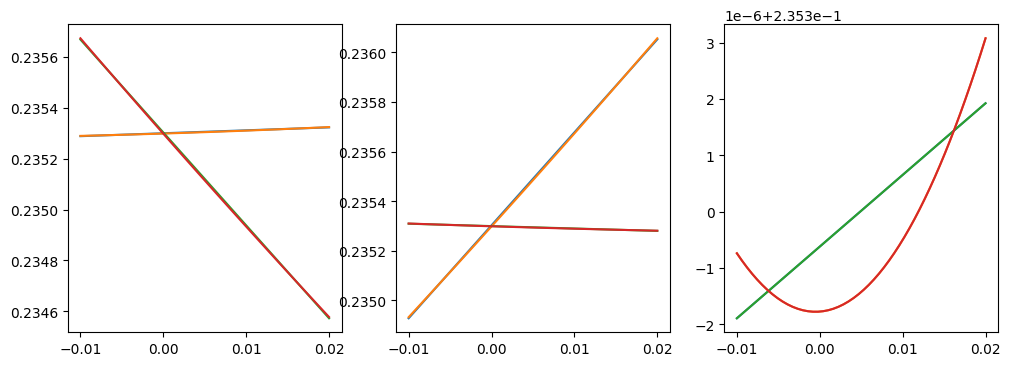

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))  # 1 row, 3 columns
ik = 0

dispFitPlot = np.linspace(dispPattern[0],dispPattern[-1],50)
vg = np.zeros((3))
R2 = np.zeros((2))
vg_fit = np.zeros((2))


for ib in range(0,2):
    for ix in range(3):
        for iorder in range(2):
            # Fit to polynomial
            p = np.polyfit(dispPattern, eigs[ik,ix,ib],iorder+1)
            
            # Get predicted values
            eigFit = np.polyval(p,dispPattern)
            eigFitPlot = np.polyval(p,dispFitPlot)
            
            # Get goodness of fit
            SSR = np.sum((eigFit-eigs[ik,ix,ib])**2)
            SST = np.sum((eigs[ik,ix,ib] - np.mean(eigs[ik,ix,ib]))**2)
            R2[iorder] = 1 - SSR/SST
            
            # vg = slope/hbar with unit conversion
            # Convert k length to Cartesian and cm
            
            vg_fit[iorder] = p[iorder]*(1/HBAR)*HARTREE_TO_EV*(1/(RECIP_TO_CART/ANG_TO_CM))
            print(f'{ib}, {ix}, {iorder+1}, {R2[iorder]:.5f}, {vg_fit[iorder]:.2e}')
            axes[ix].plot(dispFitPlot, eigFitPlot)